# Retirement Planner

---

## Environment Setup

In [3]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [4]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [5]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [6]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-07-17', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-07-17', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [7]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-07-17 00:00:00-04:00,111.13,297.77
2019-07-18 00:00:00-04:00,111.30,298.85
2019-07-19 00:00:00-04:00,111.23,297.12
2019-07-22 00:00:00-04:00,111.31,297.92
2019-07-23 00:00:00-04:00,111.20,299.98


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [8]:
# Calculate the daily roi for the stocks
daily_roi = df.pct_change()
daily_roi = daily_roi.dropna()
# Display sample data
daily_roi.head()


,AGG,SPY
,close,close
2019-07-18 00:00:00-04:00,0.001530,0.003627
2019-07-19 00:00:00-04:00,-0.000629,-0.005789
2019-07-22 00:00:00-04:00,0.000719,0.002693
2019-07-23 00:00:00-04:00,-0.000988,0.006915
2019-07-24 00:00:00-04:00,0.001439,0.004667


In [9]:
# Compute daily roi volatility
agg_daily_vol = daily_roi.std()['AGG']['close']
spy_daily_vol = daily_roi.std()['AGG']['close']

In [10]:
# Compute daily roi averagea
agg_daily_mean = daily_roi.mean()['AGG']['close']
spy_daily_mean = daily_roi.mean()['SPY']['close']

In [11]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [12]:
# Setup the Monte Carlo Parameters
num_simulations = 500
num_projected_days = 252*30
simulated_price_df = pd.DataFrame()
monte_carlo=pd.DataFrame()

In [13]:
# Run the Monte Carlo Simulation
for n in range(num_simulations):
    simulated_agg_prices_list = [agg_last_price]
    simulated_spy_prices_list = [spy_last_price]
    for i in range(num_projected_days):
        simulated_agg_price = simulated_agg_prices_list[-1] * (1 + np.random.normal(agg_daily_mean,agg_daily_vol))
        simulated_spy_price = simulated_spy_prices_list[-1] * (1+ np.random.normal(spy_daily_mean,spy_daily_vol))
        simulated_agg_prices_list.append(simulated_agg_price)
        simulated_spy_prices_list.append(simulated_spy_price)
    simulated_price_df['AGG price'] = pd.Series(simulated_agg_prices_list)
    simulated_price_df['SPY price'] = pd.Series(simulated_spy_prices_list)
    simulated_daily_return = simulated_price_df.pct_change()
    weight = [0.6,0.4]
    port_daily_return = simulated_daily_return.dot(weight)
    monte_carlo[n] = (1+ port_daily_return.fillna(0)).cumprod()

    

In [14]:
# Check that the simulation ran successfully
monte_carlo.head(-10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001730,0.997270,0.995090,1.001498,1.007570,1.002170,1.004765,1.002202,1.001246,0.997587,...,1.001876,0.994443,1.005042,1.000730,0.997041,1.002876,0.997951,0.998318,1.001088,0.996205
2,1.007669,1.001018,0.996130,0.997542,1.008642,0.996126,0.999932,0.993036,1.000285,1.001891,...,1.004322,0.999543,1.007344,1.002824,0.998088,0.996561,0.997824,0.997900,1.000088,0.999863
3,1.006740,1.000667,0.998236,0.994190,1.007360,0.995506,1.003634,0.986915,0.999937,1.009863,...,1.004496,0.998871,1.010392,1.005132,0.992182,0.996529,1.001962,0.999049,1.002930,1.000509
4,1.014145,1.003148,0.997432,0.999266,1.010230,0.993324,1.004452,0.982857,1.005412,1.004948,...,1.004571,0.998868,1.009493,1.006028,0.996461,0.994170,0.997247,1.000406,1.005001,1.002812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7546,17.801999,15.167165,18.296306,17.983620,18.978696,21.504189,14.992411,25.782574,18.699978,19.059676,...,9.156241,20.281367,14.479778,17.264464,22.988231,31.682977,10.360790,24.364210,22.648181,11.256173
7547,17.887273,15.192112,18.334737,17.826544,18.991537,21.483505,14.867399,25.524470,18.725682,19.141433,...,9.169558,20.201245,14.476776,17.318245,22.860064,31.819332,10.400176,24.321982,22.729761,11.237767
7548,17.961625,15.232233,18.274218,17.842705,18.984548,21.526340,14.953408,25.582803,18.742597,19.097914,...,9.210786,20.297909,14.513035,17.365702,22.851778,31.696014,10.408362,24.416782,22.729116,11.314308
7549,17.992823,15.415123,18.275941,17.859890,18.916303,21.464845,14.996275,25.546117,18.825582,19.047574,...,9.210463,20.238505,14.559112,17.479282,22.748687,31.878044,10.312577,24.335282,22.875751,11.342089


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Daily Return Trajectories Over the Next 30 years'}>

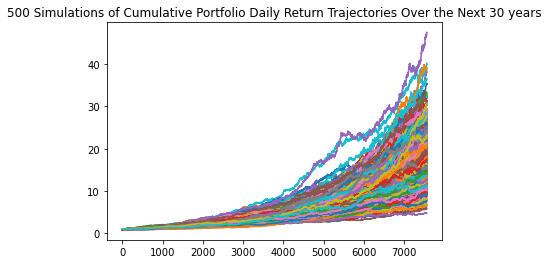

In [15]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Daily Return Trajectories Over the Next 30 years"
monte_carlo.plot(legend=None, title=plot_title)

In [16]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
end_monte_carlo = monte_carlo.iloc[-1, :]
end_monte_carlo.head()

0    18.193340
1    15.410407
2    19.132058
3    18.072674
4    18.481165
Name: 7560, dtype: float64

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
monte_carlo_20 = monte_carlo.iloc[-20, :]
monte_carlo_20.head()

0    18.201856
1    15.136700
2    18.320856
3    17.970510
4    18.892856
Name: 7541, dtype: float64

In [18]:
# Display the 90% confidence interval for the ending returns
confident_90 = end_monte_carlo.quantile(q=[0.05,0.95])
confident_90

0.05     9.209916
0.95    28.096220
Name: 7560, dtype: float64

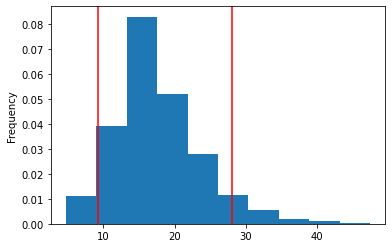

In [19]:
# Visualize the distribution of the ending returns
plt.figure();
end_monte_carlo.plot(kind='hist',density=True)
plt.axvline(confident_90.iloc[0], color='red')
plt.axvline(confident_90.iloc[1], color='red')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
# Compute cumulative returns
quantile_90_cummulative_return = end_monte_carlo.quantile(q=[0.10,0.90])
quantile_90_cummulative_return

0.1    11.102619
0.9    25.436924
Name: 7560, dtype: float64

In [21]:
quantile_50_cummulative_return = end_monte_carlo.quantile(0.50)
quantile_50_cummulative_return

16.711112434816894

In [55]:
quantile = [quantile_90_cummulative_return.iloc[0],quantile_50_cummulative_return,quantile_90_cummulative_return.iloc[1]]
quantile

[11.102619460279454, 16.711112434816894, 25.43692449815284]

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [56]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
expected_port_return = initial_investment*np.array(quantile)
expected_port_return

array([222052.38920559, 334222.24869634, 508738.48996306])

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [57]:
# Set Plaid's projected income
projected_income = 7285

# Calculate the 4% withdrawal for the ending return as retirement income. 
# Assume this client expect to live another 30 years after retirement.
retirement_income = 0.04*np.array(expected_port_return)/30
retirement_income

array([296.06985227, 445.62966493, 678.31798662])

In [58]:
# Determine if the retirement income meets or exceeds the current projected income.
retire_sustain_withdrawal_rate = (retirement_income[0] > projected_income)
print(f"True or False: retirement income is higher than client's projected income: {retire_sustain_withdrawal_rate}")

True or False: retirement income is higher than client's projected income: False


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [59]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment_upsize = 1.5*initial_investment
expected_port_return_upsize = initial_investment_upsize*np.array(quantile)
retirement_income_upsize = 0.04*np.array(expected_port_return_upsize)/30
retire_sustain_withdrawal_rate_2 =(retirement_income_upsize[0] > projected_income)
print(f"True or False: retirement income is higher than client's projected income when increse initial investment by 50%: {retire_sustain_withdrawal_rate_2}")

True or False: retirement income is higher than client's projected income when increse initial investment by 50%: False


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [32]:
# Compute projected returns
return_range = pd.DataFrame()
quantile_5 = []
quantile_50 = []
quantile_95 = []
for n in range(num_projected_days):
    a = monte_carlo.iloc[n, :].quantile(0.05)
    b = monte_carlo.iloc[n, :].quantile(0.50)
    c = monte_carlo.iloc[n, :].quantile(0.95)
    quantile_5.append(a)
    quantile_50.append(b)
    quantile_95.append(c)
return_range['5th Quantile'] = pd.Series(quantile_5)
return_range['Mean'] = pd.Series(quantile_50)
return_range['95th Quantile'] = pd.Series(quantile_95)
# Display sample data
return_range.head()

,5th Quantile,Mean,95th Quantile
0,1.000000,1.000000,1.000000
1,0.993515,1.000561,1.007514
2,0.991775,1.001140,1.009760
3,0.990116,1.001188,1.012430
4,0.988667,1.001956,1.014982


<AxesSubplot:title={'center':'Projected Cumulative Return'}>

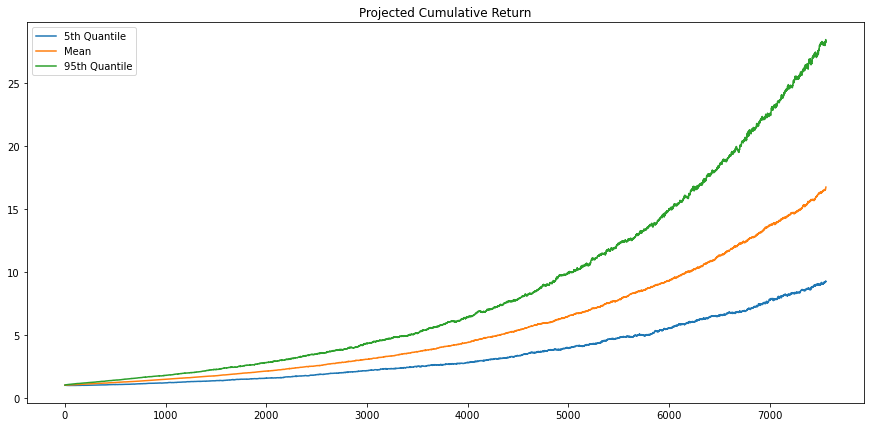

In [33]:
# Plot the cumulative returns over time
return_range.plot(figsize=(15,7), title='Projected Cumulative Return')

In [29]:
# Compute portfolio performance over time
historical_daily_performance = daily_roi.dot(weight)
historical_cummulative_performance = (1+historical_daily_performance).cumprod()

C:\Users\khuli\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:title={'center':'1Y Historical Performance, Cumulative Return'}>

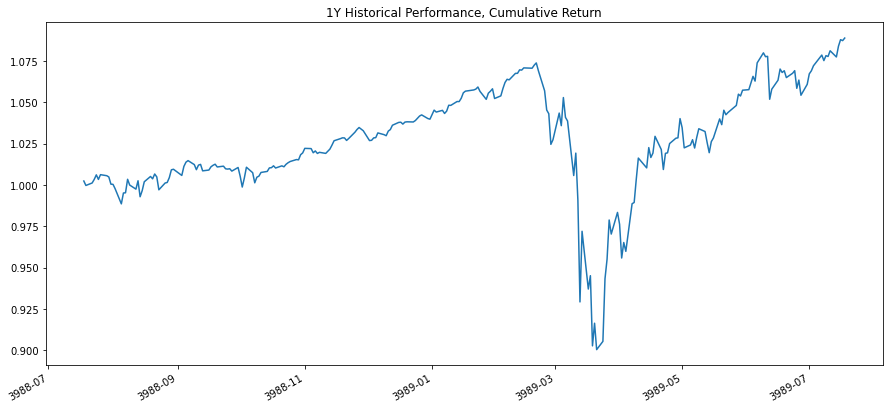

In [30]:
# Plot projected performance over time
historical_cummulative_performance.plot(figsize=(15,7), title='1Y Historical Performance, Cumulative Return')